# Caption Generation
    >Python编程
    >Keras及其模块
    >卷积神经网络及其实现
    >RNN和LSTM
    >转移学习

## 零、模型说明
### 01 数据集说明
##### 数据集：Flickr8k
##### 数据集划分：train:test = 4:1
### 02 算法说明
##### RNN LSTM 贪心算法
###  03 模型训练环境
##### CPU
##### 参数说明：

## 一、导入所需要的库

In [4]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time
# import os.listdir('/bin')

# 利用keras库创建模型并进行训练
from keras import Input, layers
from keras import optimizers
from keras.optimizers import adam_v2
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

## 二、数据加载和预处理

### 2.1 导入数据集所在路径并保存所有图片

In [70]:
# 导入数据集所在路径并保存所有图片。
token_path = 'D://pythonProject/pythonProject1/Flickr_TextData/Flickr8k.token.txt'
train_images_path = 'D://pythonProject/pythonProject1/Flickr_TextData/Flickr_8k.trainImages.txt'
test_images_path = 'D://pythonProject/pythonProject1/Flickr_TextData/Flickr_8k.testImages.txt'
images_path = 'D://pythonProject/pythonProject1/Images/'
glove_path = 'D://pythonProject/pythonProject1/'

doc = open(token_path, 'r').read()
print('图片编号及对应的文本标签：\n',doc[:800])
print('————————————————')
# doc_train_images = open(train_images_path, 'r').read()
# print('训练集图片编号：\n',doc_train_images[:283])
# print('————————————————')
# doc_test_images = open(test_images_path, 'r').read()
# print('测试集图片编号：\n',doc_test_images[:411])

图片编号及对应的文本标签：
 1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457
————————————————


### 2.2 创建一个字典，以图片ID为键，以每张图片相对应的五个captions为对

In [71]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

print(descriptions)

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'], '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting

### 2.3 进行数据预处理，把文本中的大写全部改成小写并删除标点符号

In [72]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)
print(table)


{33: None, 34: None, 35: None, 36: None, 37: None, 38: None, 39: None, 40: None, 41: None, 42: None, 43: None, 44: None, 45: None, 46: None, 47: None, 58: None, 59: None, 60: None, 61: None, 62: None, 63: None, 64: None, 91: None, 92: None, 93: None, 94: None, 95: None, 96: None, 123: None, 124: None, 125: None, 126: None}


### 2.4 将案例图片可视化

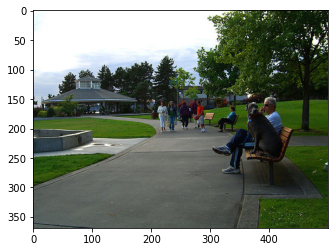

['a man and a dog are sitting on a park bench with several people walking down the path that runs alongside it ',
 'a man and a dog on a park bench in the foreground  with a group of walking people in the distance ',
 'a man sits on a bench in the park with a dog  while others walk nearby ',
 'people sit on a park bench while others jog on a path ',
 'the man sits with his dog on a bench in a park ']

In [73]:
pic = '42637987_866635edf6.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['42637987_866635edf6']

### 2.5 接下来，我们创建数据集中所有8000 * 5（即40000）个captions中存在的所有唯一单词的词汇表。 我们在所有40000个图像标题中有8828个唯一的单词。

In [74]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


### 2.6 现在，以与token.txt文件相同的格式保存ID及其清洗后的的captions：

In [75]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)
print(lines)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 2.7 从“ Flickr_8k.trainImages.txt”文件中加载所有6000个训练图像ID：

In [76]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)


### 2.8 现在，我们将所有训练和测试图像分别保存在train_img和test_img列表中：

In [77]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img:
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img:
    if i[len(images_path):] in test_images:
        test_img.append(i)
#print(train_img)

### 2.9 将训练图像的captions加载到字典中。 我们将在每个标题中添加两个标记，分别是“startseq”和“endseq”：

In [78]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)
print(train_descriptions)

{'1000268201_693b08cb0e': ['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq', 'startseq a girl going into a wooden building endseq', 'startseq a little girl climbing into a wooden playhouse endseq', 'startseq a little girl climbing the stairs to her playhouse endseq', 'startseq a little girl in a pink dress going into a wooden cabin endseq'], '1001773457_577c3a7d70': ['startseq a black dog and a spotted dog are fighting endseq', 'startseq a black dog and a tricolored dog playing with each other on the road endseq', 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq'], '1002674143_1b742ab4b8': ['startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq', 'startseq a little girl is sitting in front of a lar

### 2.10 创建所有训练标题的列表：

In [79]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
print(all_train_captions)

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq', 'startseq a girl going into a wooden building endseq', 'startseq a little girl climbing into a wooden playhouse endseq', 'startseq a little girl climbing the stairs to her playhouse endseq', 'startseq a little girl in a pink dress going into a wooden cabin endseq', 'startseq a black dog and a spotted dog are fighting endseq', 'startseq a black dog and a tricolored dog playing with each other on the road endseq', 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq', 'startseq two dogs of different breeds looking at each other on the road endseq', 'startseq two dogs on pavement moving toward each other endseq', 'startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq', 'startseq a little girl is sitting in front of a large painted rainbow endseq', 'startseq a small girl in the grass plays with finge

### 2.11 为了使模型更加健壮，我们将词汇量减少到仅在整个语料库中出现至少10次的单词。

In [80]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


### 2.12 创建两个字典以将单词映射到索引，反之亦然。 另外，我们在词汇表后面加上1，因为我们在后面加上0以使所有字幕的长度相等。

In [81]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

### 2.13 因此，现在总词汇量为1660。还需要找出字幕的最大长度，因为我们不能有任意长度的字幕。

In [82]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


## 三、Glove嵌入

### 3.1 词向量将词映射到向量空间，在这里类似的词被聚在一起，而不同的词则被分离。
### 与Word2Vec相比，使用Glove的优势在于GloVe不仅依赖于单词的局部上下文，还合并了全局单词共现以获得单词向量。
### Glove背后的基本前提是我们可以从同现矩阵中得出单词之间的语义关系。对于我们的模型，我们将使用Glove将38字长标题中的所有字映射到200维向量。


In [83]:
embeddings_index = {}
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

### 3.2 接下来，我们制作形状矩阵（1660,200），该矩阵由我们的词汇表和200维向量组成。

In [84]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## 四、建立模型

### 4.1 我们选择使用InceptionV3网络进行转移学习，该网络在ImageNet数据集上进行了预训练。

In [85]:
model = InceptionV3(weights='imagenet')

### 4.2 这里不需要分类图像，只需要为图像提取图像矢量即可。因此，我们从inceptionV3模型中删除了softmax层。

In [86]:
model_new = Model(model.input, model.layers[-2].output)

### 4.3 我们用的是InceptionV3，因此需要对输入进行预处理，然后再将其输入模型。
### 因此，我们定义了一个预处理函数以将图像重塑为（299 x 299）并馈入Keras的preprocess_input（）函数。

In [87]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

### 4.4 现在我们可以继续对训练和测试图像进行编码，即提取形状为（2048，）的图像矢量

In [88]:
def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

### 4.5 我们创建一个合并模型，其中我们将图像矢量和部分标题结合在一起。
###  因此，我们的模型将包含3个主要步骤：
#### 处理文本中的序列
#### 从图像中提取特征向量
#### 通过连接以上两层，使用softmax解码输出

In [89]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332000      input_4[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

##### Input_3是输入到嵌入层的最大长度为34的部分标题。 这是单词映射到200-d手套嵌入的地方。 紧随其后的是0.5的落差，以避免过度拟合。 然后将其输入LSTM中以处理序列。

##### Input_2是我们的InceptionV3网络提取的图像矢量。 紧随其后的是0.5的落差，以避免过度拟合，然后将其馈入“全连接”层。

##### 然后，通过添加图像模型和语言模型将其连接起来，并馈入另一个“完全连接”层。 该层是softmax层，可为我们的1660个单词词汇提供概率。

## 五、训练模型

### 5.1 在训练模型之前，我们需要记住，我们不想在嵌入层（预训练的Glove向量）中重新训练权重。

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

### 5.2 接下来，使用Categorical_Crossentropy作为Loss函数并使用Adam作为优化器来编译模型。

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

### 5.3 由于我们的数据集有6000张图像和40000个标题，我们将创建一个可以批量训练数据的函数。

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

### 5.4 接下来，让我们训练30个时期的模型，批处理大小为3，每个时期2000步。 在Kaggle GPU上，模型的完整训练耗时1小时40分钟。

In [ ]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

## 六、贪心搜索

### 6.1 当模型生成一个1660长的矢量时，该矢量在词汇表中所有单词的概率分布上，我们会贪婪地选择具有最高概率的单词以进行下一个单词预测。 此方法称为贪心搜索。

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### 6.2 Beam Search是我们获取前k个预测的地方，将其再次输入模型中，然后使用模型返回的概率对其进行排序。 因此，列表将始终包含前k个预测，并且我们选择概率最高的预测，直到遇到“ endseq”或达到最大字幕长度为止。

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp                                                                                                                                                                                                                                                                                                                                                 

    final_caption = ' '.join(final_caption[1:])
    return final_caption

## 七、模型评估

### 7.1 现在，我们在不同的图像上测试模型，并查看其生成的caption。
### 我们还将研究由贪婪搜索和Beam搜索生成的具有不同k值的不同caption。
### 首先，我们将看一下本文开头看到的示例图像。
### 我们看到图caption是“雪中的黑狗和棕狗”。
### 让我们看看我们的模型如何比较。

In [ ]:
'''
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))
'''
